# ORIE 5730 Final Project LSTM Section Code - Simple (Excluding Cash)

### 1. Data Preparation

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from keras.regularizers import l2

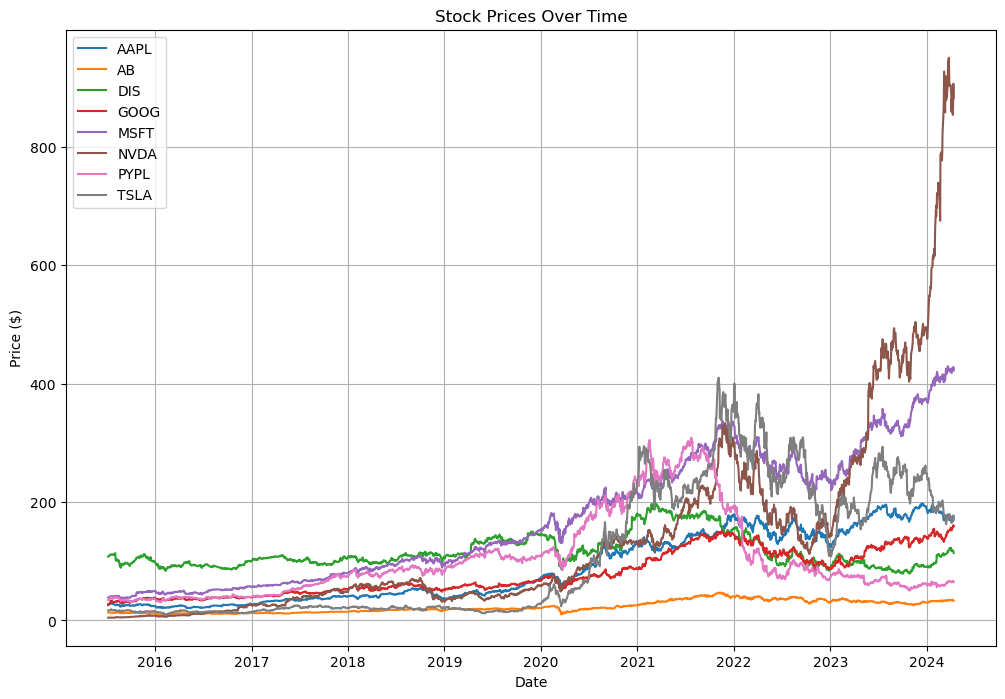

In [3]:

np.random.seed(4)
random.seed(4)
tf.random.set_seed(4)
import sys
sys.path.append('D:\\Cornell\\Spring 2024\\ORIE 5370\\Project')

# Load the data
df = pd.read_excel('combined stock returns.xlsx', index_col='Date', parse_dates=True)

returns_columns = ['AAPL_Return', 'AB_Return', 'DIS_Return', 'GOOG_Return',
                   'MSFT_Return', 'NVDA_Return', 'PYPL_Return', 'TSLA_Return']
prices_columns = ['AAPL', 'AB', 'DIS', 'GOOG', 'MSFT', 'NVDA', 'PYPL', 'TSLA']


all_features = pd.concat([df[returns_columns], df[prices_columns]], axis=1)


split_point = int(len(all_features) * 0.8)
end_point = int(len(all_features) * 0.992)
train_data = all_features[:split_point]
test_data = all_features[split_point:end_point]

# Data Scalling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Define sequence length and generate sequences
sequence_length = 60
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)
# print(df.head())
# print(df.shape)

# Plotting the prices of all stocks
plt.figure(figsize=(12, 8))
plt.plot(df['AAPL'], label='AAPL')
plt.plot(df['AB'], label='AB')
plt.plot(df['DIS'], label='DIS')
plt.plot(df['GOOG'], label='GOOG')
plt.plot(df['MSFT'], label='MSFT')
plt.plot(df['NVDA'], label='NVDA')
plt.plot(df['PYPL'], label='PYPL')
plt.plot(df['TSLA'], label='TSLA')

plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()  
plt.grid(True)
plt.show()

### 2. Optimization

In [5]:
model = Sequential()
# Add LSTM layers
model.add(LSTM(89, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2]), 
               kernel_regularizer=l2(0.01))) 
model.add(Dropout(0.2))


# Add Dense layers for output prediction
model.add(Dense(y_train.shape[1]))
model.add(Dense(y_train.shape[1], kernel_regularizer=l2(0.01)))

# Compile the model with Adam optimizer and mean squared error loss
model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\james\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.4898 - val_loss: 0.3164
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2301 - val_loss: 0.1852
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1364 - val_loss: 0.1278
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0915 - val_loss: 0.0972
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0659 - val_loss: 0.0779
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0489 - val_loss: 0.0645
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0372 - val_loss: 0.0579
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0286 - val_loss: 0.0509
Epoch 9/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0218 - val_loss: 0.0463
Epoch 10/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0172 - val_loss: 0.0425
Epoch 11/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0142 - val_loss: 0.0411
Epoch 12/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0

In [7]:
print(len(X_test)/len(X_train))
print(len(X_train))

0.21348973607038124
1705


In [ ]:
history_df = pd.DataFrame(history.history)
history_df.plot()

In [9]:
def sharpe_ratio(weights, returns):
    portfolio_return = np.dot(returns.mean(), weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return -portfolio_return / portfolio_std  # Negative because we minimize this function

In [10]:
# Optimization set-up
num_assets = len(prices_columns)
initial_weights = np.full(num_assets, 1.0 / num_assets)
bounds = [(0.0, 1/5) for _ in range(num_assets)]
constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]

rebalance_period = 20

optimal_weights = []
rebalance_dates = []

for i in range(0, len(X_test), rebalance_period):
    start_idx = i
    end_idx = min(i + rebalance_period, len(X_test))
    
    current_period_X = X_test[start_idx:end_idx]
    predicted_returns = model.predict(current_period_X)
    actual_length = current_period_X.shape[0]
    predicted_returns_only = predicted_returns[:actual_length, :len(returns_columns)]
    predicted_returns_df = pd.DataFrame(predicted_returns_only, columns=returns_columns)

    if start_idx + sequence_length < len(test_data):
        rebalance_date = test_data.index[start_idx + sequence_length]
        rebalance_dates.append(rebalance_date)

    # Perform portfolio optimization
    results = minimize(sharpe_ratio, initial_weights, args=(predicted_returns_df,),
                       method='SLSQP', bounds=bounds, constraints=constraints)
    optimal_weights.append(results.x)

    if end_idx == len(X_test):
        break


optimal_weights_df = pd.DataFrame(optimal_weights, columns=returns_columns, index=rebalance_dates)
print(rebalance_dates)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
[Timestamp('2022-10-05 00:00:00'), Timestamp('2022-11-02 00:00:00'), Timestamp('2022-12-01 00:00:00'), Timestamp('2022-12-30 00:00:00'), Timestamp('2023-01-31 00:00:00'), Timestamp('2023-03-01 00:00:00'), Timestamp('2023-03-29 00:00:00'), Timestamp('2023-04-27 00:00:00'), Tim

In [11]:
optimal_weights_df.sort_index(inplace=True)
print(optimal_weights_df)

            AAPL_Return     AB_Return  DIS_Return  GOOG_Return  MSFT_Return  \
2022-10-05     0.000000  2.000000e-01    0.200000     0.000000     0.200000   
2022-11-02     0.000000  2.000000e-01    0.200000     0.000000     0.200000   
2022-12-01     0.200000  2.000000e-01    0.000000     0.200000     0.197734   
2022-12-30     0.200000  2.000000e-01    0.200000     0.000000     0.200000   
2023-01-31     0.000000  0.000000e+00    0.000000     0.200000     0.200000   
2023-03-01     0.200000  0.000000e+00    0.000000     0.200000     0.200000   
2023-03-29     0.200000  0.000000e+00    0.000000     0.200000     0.200000   
2023-04-27     0.200000  2.391862e-02    0.000000     0.200000     0.200000   
2023-05-25     0.200000  0.000000e+00    0.000000     0.200000     0.200000   
2023-06-26     0.000000  2.000000e-01    0.200000     0.200000     0.200000   
2023-07-25     0.199982  4.916267e-05    0.000069     0.199941     0.199993   
2023-08-22     0.200000  1.712789e-01    0.000001   

### 3. Simple LSTM

In [12]:
## Backtest of optimal portfolio
initial_capital = 100000
print(test_data)
initial_prices = df.loc[test_data.index[0], prices_columns].values

portfolio_values = [initial_capital] 

for date in optimal_weights_df.index:
    weights = optimal_weights_df.loc[date].values
    prices = df.loc[date, prices_columns].values
    
    normalized_value = np.sum(weights * prices) / np.sum(weights * initial_prices)
    portfolio_value = normalized_value * initial_capital
    portfolio_values.append(portfolio_value)

portfolio_values_df = pd.DataFrame(portfolio_values, columns=['Portfolio Value'], index=[test_data.index[0]] + list(optimal_weights_df.index))


            AAPL_Return  AB_Return  DIS_Return  GOOG_Return  MSFT_Return  \
Date                                                                       
2022-07-12     0.006834  -0.000244   -0.000427    -0.014358    -0.040982   
2022-07-13    -0.002537  -0.005608   -0.007051    -0.023183    -0.003745   
2022-07-14     0.020482  -0.008583   -0.011836    -0.006658     0.005381   
2022-07-15     0.011450   0.014840    0.036585     0.011908     0.010391   
2022-07-18    -0.020643  -0.027297    0.005252    -0.025335    -0.009622   
...                 ...        ...         ...          ...          ...   
2024-03-12     0.002779   0.008923    0.001336     0.004894     0.026599   
2024-03-13    -0.012123   0.005307    0.000356     0.008237    -0.000433   
2024-03-14     0.010927  -0.021408   -0.003911     0.025360     0.024380   
2024-03-15    -0.002197  -0.002397   -0.000982    -0.015034    -0.020695   
2024-03-18     0.006372   0.005707    0.016972     0.044383     0.002161   

           

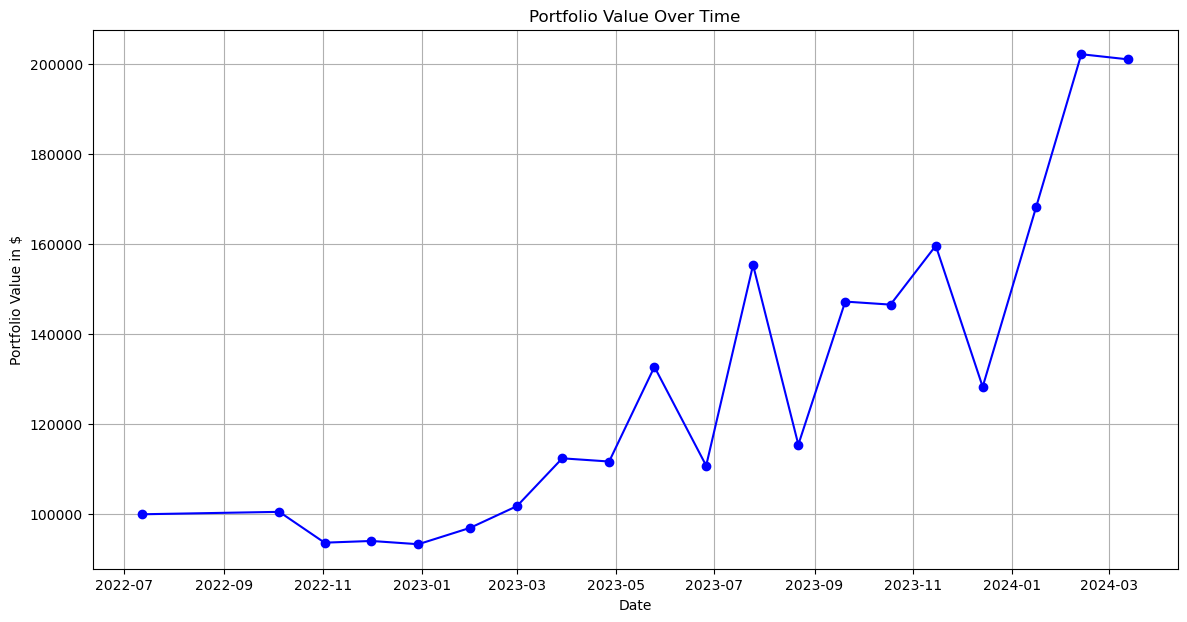

In [13]:

plt.figure(figsize=(14, 7))
plt.plot(portfolio_values_df.index, portfolio_values_df['Portfolio Value'], marker='o', linestyle='-', color='b')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value in $')
plt.grid(True)
plt.show()

### 3. Metrices

In [25]:
portfolio_df = portfolio_values_df
# Calculate annual returns
portfolio_df['Month'] = portfolio_df.index.month
Monthly_returns = portfolio_df['Portfolio Value']/portfolio_df['Portfolio Value'].shift(1)-1

# Calculate cumulative return
cumulative_return = portfolio_df['Portfolio Value'].iloc[-1] / portfolio_df['Portfolio Value'].iloc[0] - 1
# Calculate running maximum of the portfolio value
portfolio_df['Running Max'] = portfolio_df['Portfolio Value'].cummax()

# Calculate drawdown: how much the portfolio has fallen from the running maximum
portfolio_df['Drawdown'] = (portfolio_df['Running Max'] - portfolio_df['Portfolio Value']) / portfolio_df['Running Max']

# Calculate maximum drawdown
max_drawdown = portfolio_df['Drawdown'].max()
print("Annual Returns:")
print(Monthly_returns)
print("\nCumulative Return:", cumulative_return)
# Output maximum drawdown
print("Maximum Drawdown:", max_drawdown)

Annual Returns:
2022-07-12         NaN
2022-10-05   -0.000840
2022-11-02   -0.062231
2022-12-01    0.130970
2022-12-30   -0.261468
2023-01-31    0.315689
2023-03-01   -0.006935
2023-03-29    0.099469
2023-04-27    0.006895
2023-05-25    0.172358
2023-06-26    0.078301
2023-07-25    0.085282
2023-08-22   -0.049807
2023-09-20   -0.190334
2023-10-18    0.226299
2023-11-15    0.089223
2023-12-14    0.004244
2024-01-16    0.048845
2024-02-13    0.094299
2024-03-13    0.099324
Name: Portfolio Value, dtype: float64

Cumulative Return: 1.022252488203585
Maximum Drawdown: 0.261467899669295


### 4. Enhanced Simple LSTM

In [24]:
initial_capital = 100000
print("Test data:")
print(test_data)
initial_prices = df.loc[test_data.index[0], prices_columns].values

# List to hold the portfolio values
portfolio_values = [initial_capital] 
historical_max = initial_capital+10000  # Start with initial capital as the initial historical maximum

# Data structures for weights and rebalance dates
weights = initial_weights  # Start with the initial weights defined elsewhere in your setup

for date in optimal_weights_df.index:
    prices = df.loc[date, prices_columns].values
    normalized_value = np.sum(weights * prices) / np.sum(weights * initial_prices)
    portfolio_value = normalized_value * initial_capital
    
    # Check if current portfolio value is a new historical maximum
    if portfolio_value > historical_max:
        historical_max = portfolio_value  # Update historical maximum
        print(f"New historical max reached on {date}: {portfolio_value}")
    else:
        # Only update weights if not at a historical maximum
        weights = optimal_weights_df.loc[date].values  # Update weights from the dataframe of optimal weights
    
    # Append the current or updated portfolio value
    portfolio_values.append(portfolio_value)

# Create a DataFrame from the portfolio values
portfolio_values_df = pd.DataFrame(portfolio_values, columns=['Portfolio Value'], index=[test_data.index[0]] + list(optimal_weights_df.index))

Test data:
            AAPL_Return  AB_Return  DIS_Return  GOOG_Return  MSFT_Return  \
Date                                                                       
2022-07-12     0.006834  -0.000244   -0.000427    -0.014358    -0.040982   
2022-07-13    -0.002537  -0.005608   -0.007051    -0.023183    -0.003745   
2022-07-14     0.020482  -0.008583   -0.011836    -0.006658     0.005381   
2022-07-15     0.011450   0.014840    0.036585     0.011908     0.010391   
2022-07-18    -0.020643  -0.027297    0.005252    -0.025335    -0.009622   
...                 ...        ...         ...          ...          ...   
2024-03-12     0.002779   0.008923    0.001336     0.004894     0.026599   
2024-03-13    -0.012123   0.005307    0.000356     0.008237    -0.000433   
2024-03-14     0.010927  -0.021408   -0.003911     0.025360     0.024380   
2024-03-15    -0.002197  -0.002397   -0.000982    -0.015034    -0.020695   
2024-03-18     0.006372   0.005707    0.016972     0.044383     0.002161   



### Equal-weighted Portfolio

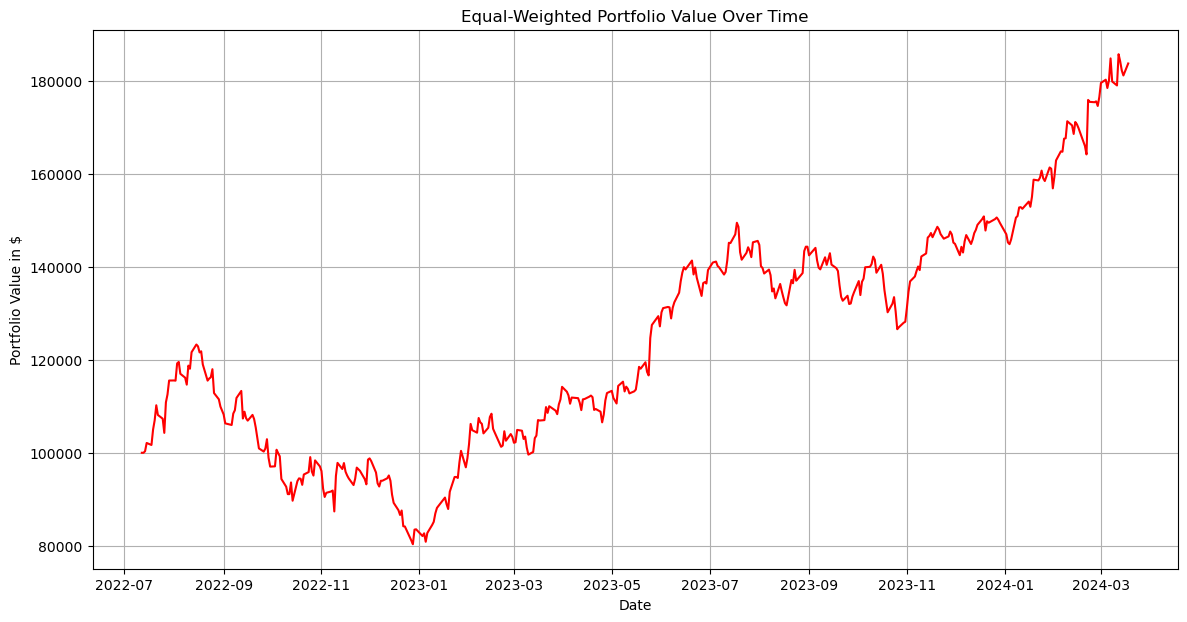

In [21]:
initial_capital = 100000
initial_prices = df.loc[test_data.index[0], prices_columns].values

num_assets = len(prices_columns)
equal_weights = np.full(num_assets, 1.0 / num_assets)

# List to hold the portfolio values, starts empty.
equal_weighted_portfolio_values = []

# Calculate the first portfolio value and append it
normalized_initial_value = np.sum(equal_weights * initial_prices) / np.sum(equal_weights * initial_prices)
initial_portfolio_value = normalized_initial_value * initial_capital
equal_weighted_portfolio_values.append(initial_portfolio_value)

# Loop over the test data indices starting from the first date
for date in test_data.index:
    prices = df.loc[date, prices_columns].values
    normalized_value = np.sum(equal_weights * prices) / np.sum(equal_weights * initial_prices)
    portfolio_value = normalized_value * initial_capital
    equal_weighted_portfolio_values.append(portfolio_value)

# Create a DataFrame from the values
equal_weighted_portfolio_values_df = pd.DataFrame(equal_weighted_portfolio_values, columns=['Portfolio Value'], index=test_data.index.insert(0, test_data.index[0]))

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(equal_weighted_portfolio_values_df.index, equal_weighted_portfolio_values_df['Portfolio Value'], linestyle='-', color='r')
plt.title('Equal-Weighted Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value in $')
plt.grid(True)
plt.show()

### 5. Comparison with Equal-weighted

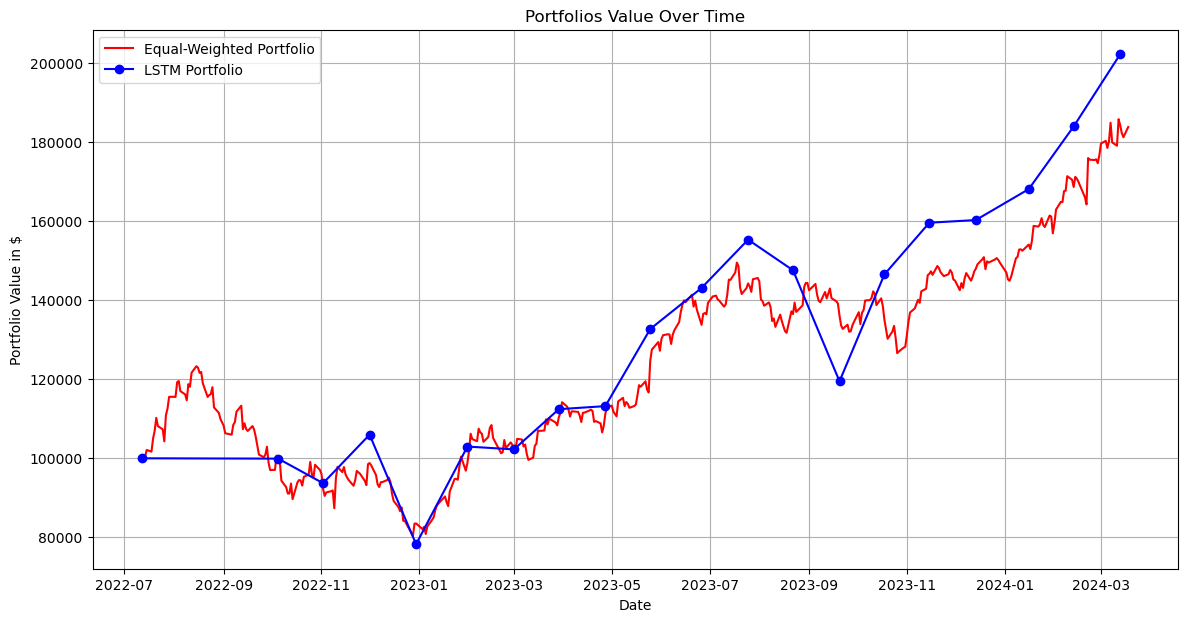

In [17]:

plt.figure(figsize=(14, 7))
plt.plot(equal_weighted_portfolio_values_df.index, equal_weighted_portfolio_values_df['Portfolio Value'], linestyle='-', color='r')
plt.plot(portfolio_values_df.index, portfolio_values_df['Portfolio Value'], marker='o', linestyle='-', color='b')
plt.legend(['Equal-Weighted Portfolio', 'LSTM Portfolio'])
plt.title('Portfolios Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value in $')
plt.grid(True)
plt.show()

### Switching Model (Not included)

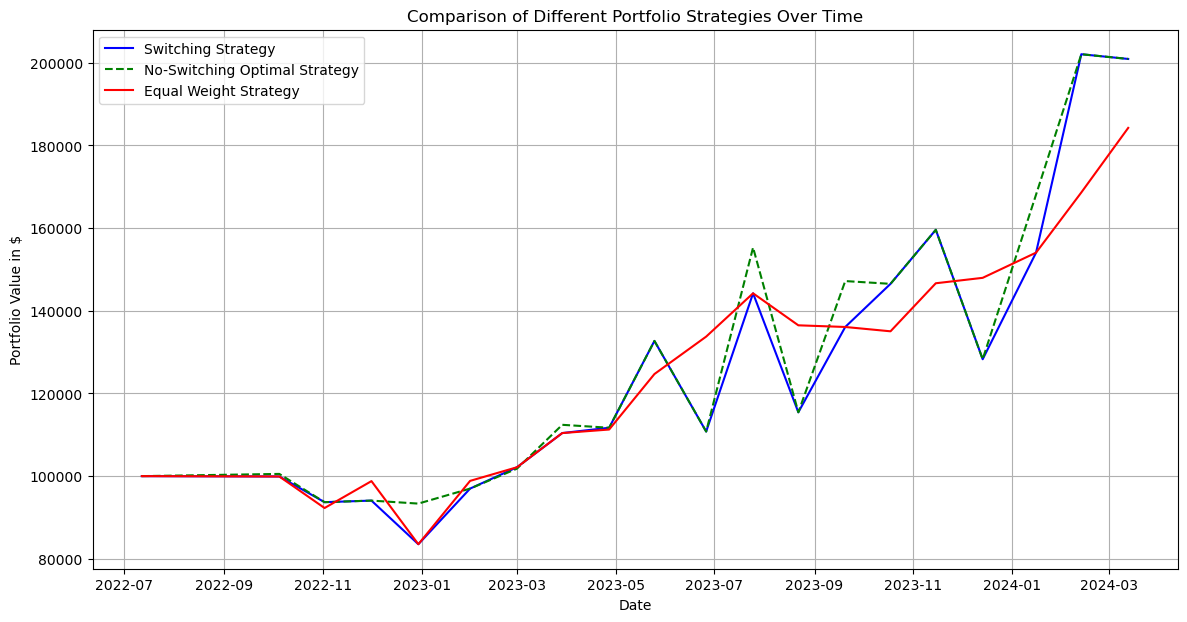

In [18]:
initial_capital = 100000
initial_prices = df.loc[test_data.index[0], prices_columns].values

num_assets = len(prices_columns)
equal_weights = np.full(num_assets, 1.0 / num_assets)

# Initialize portfolio values for all strategies
switching_portfolio_values = [initial_capital]
no_switching_portfolio_values = [initial_capital]
equal_weighted_portfolio_values = [initial_capital]

current_weights = equal_weights  # Start with equal weights for switching strategy
current_strategy = "equal"  # Start with equal weight strategy for switching strategy

for date in optimal_weights_df.index:
    prices = df.loc[date, prices_columns].values

    # Calculate portfolio value for equal weights
    equal_normalized_value = np.sum(equal_weights * prices) / np.sum(equal_weights * initial_prices)
    equal_portfolio_value = equal_normalized_value * initial_capital

    # Calculate portfolio value for optimal weights
    if date in optimal_weights_df.index:
        optimal_weights = optimal_weights_df.loc[date].values
    optimal_normalized_value = np.sum(optimal_weights * prices) / np.sum(optimal_weights * initial_prices)
    optimal_portfolio_value = optimal_normalized_value * initial_capital

    # Append values for the no-switching optimal strategy
    no_switching_portfolio_values.append(optimal_portfolio_value)

    # Append values computed with the current strategy for switching
    if current_strategy == "optimal":
        switching_portfolio_values.append(optimal_portfolio_value)
    else:
        switching_portfolio_values.append(equal_portfolio_value)

    # Decide which strategy to use for the next period in the switching strategy
    if optimal_portfolio_value < equal_portfolio_value:
        current_weights = equal_weights
        current_strategy = "equal"
    else:
        current_weights = optimal_weights
        current_strategy = "optimal"

    equal_weighted_portfolio_values.append(equal_portfolio_value)

# Create DataFrames to store the portfolio values
switching_portfolio_values_df = pd.DataFrame(switching_portfolio_values, columns=['Switching Portfolio Value'], index=[test_data.index[0]] + list(optimal_weights_df.index))
no_switching_portfolio_values_df = pd.DataFrame(no_switching_portfolio_values, columns=['No-Switching Portfolio Value'], index=[test_data.index[0]] + list(optimal_weights_df.index))
equal_weighted_portfolio_values_df = pd.DataFrame(equal_weighted_portfolio_values, columns=['Equal Weighted Portfolio Value'], index=[test_data.index[0]] + list(optimal_weights_df.index))

# Plotting all strategies for comparison
plt.figure(figsize=(14, 7))
plt.plot(switching_portfolio_values_df.index, switching_portfolio_values_df['Switching Portfolio Value'], linestyle='-', color='b', label='Switching Strategy')
plt.plot(no_switching_portfolio_values_df.index, no_switching_portfolio_values_df['No-Switching Portfolio Value'], linestyle='--', color='g', label='No-Switching Optimal Strategy')
plt.plot(equal_weighted_portfolio_values_df.index, equal_weighted_portfolio_values_df['Equal Weighted Portfolio Value'], linestyle='-', color='r', label='Equal Weight Strategy')
plt.title('Comparison of Different Portfolio Strategies Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value in $')
plt.legend()
plt.grid(True)
plt.show()


### Potential future enhancement: including a buy/sell singnal (not included)

In [19]:
initial_capital = 100000
print(test_data)
initial_prices = df.loc[test_data.index[0], prices_columns].values

portfolio_values = [initial_capital]
cash = initial_capital  # Cash held after selling stocks
in_market = True  # Whether we are currently invested in the stocks

for date in optimal_weights_df.index:
    weights = optimal_weights_df.loc[date].values
    prices = df.loc[date, prices_columns].values
    
    normalized_value = np.sum(weights * prices) / np.sum(weights * initial_prices)
    portfolio_value = normalized_value * initial_capital
    portfolio_values.append(portfolio_value)

# Implementing revised strategy
portfolio_values_df = pd.DataFrame(portfolio_values, columns=['Portfolio Value'], index=[test_data.index[0]] + list(optimal_weights_df.index))
portfolio_values_df['SMA_10'] = portfolio_values_df['Portfolio Value'].rolling(window=5).mean()

# Signals
portfolio_values_df['Sell_Signal'] = (portfolio_values_df['Portfolio Value'] < portfolio_values_df['SMA_10']).astype(int).rolling(window=3).sum() == 3
portfolio_values_df['Buy_Signal'] = (portfolio_values_df['Portfolio Value'] > portfolio_values_df['SMA_10']).astype(int).rolling(window=3).sum() == 3

# Applying signals
for i in range(1, len(portfolio_values_df)):
    if portfolio_values_df['Sell_Signal'].iloc[i] and in_market:
        cash = portfolio_values_df['Portfolio Value'].iloc[i]
        in_market = False
    elif portfolio_values_df['Buy_Signal'].iloc[i] and not in_market:
        initial_capital = cash  # Reinvest the cash held
        in_market = True
    portfolio_values_df['Portfolio Value'].iloc[i] = cash if not in_market else portfolio_values_df['Portfolio Value'].iloc[i]

            AAPL_Return  AB_Return  DIS_Return  GOOG_Return  MSFT_Return  \
Date                                                                       
2022-07-12     0.006834  -0.000244   -0.000427    -0.014358    -0.040982   
2022-07-13    -0.002537  -0.005608   -0.007051    -0.023183    -0.003745   
2022-07-14     0.020482  -0.008583   -0.011836    -0.006658     0.005381   
2022-07-15     0.011450   0.014840    0.036585     0.011908     0.010391   
2022-07-18    -0.020643  -0.027297    0.005252    -0.025335    -0.009622   
...                 ...        ...         ...          ...          ...   
2024-03-12     0.002779   0.008923    0.001336     0.004894     0.026599   
2024-03-13    -0.012123   0.005307    0.000356     0.008237    -0.000433   
2024-03-14     0.010927  -0.021408   -0.003911     0.025360     0.024380   
2024-03-15    -0.002197  -0.002397   -0.000982    -0.015034    -0.020695   
2024-03-18     0.006372   0.005707    0.016972     0.044383     0.002161   

           

C:\Users\james\AppData\Local\Temp\ipykernel_22316\1602417793.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio_values_df['Portfolio Value'].iloc[i] = cash if not in_market else portfolio_values_df['Portfolio Value'].iloc[i]


<Axes: >

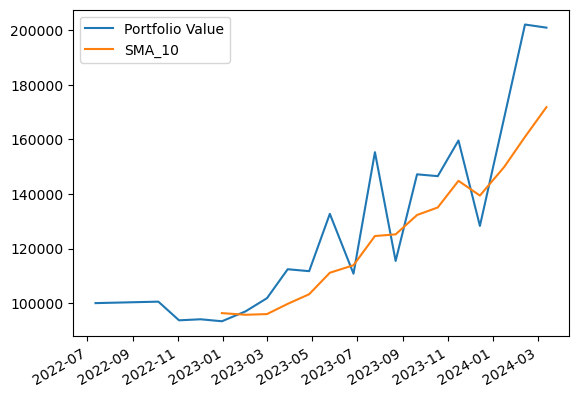

In [20]:
portfolio_values_df.plot()